In [52]:
import matplotlib.pyplot as mplot
import numpy as np

import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [53]:
df = pd.read_csv("train.csv",parse_dates=['date'])


In [54]:
df.head()


,Id,region,date,mortality_rate,O3,PM10,PM25,NO2,T2M
0,1,E12000001,2007-01-02,2.264,42.358,9.021,NaN,NaN,278.138
1,2,E12000001,2007-01-03,2.030,49.506,5.256,NaN,NaN,281.745
2,3,E12000001,2007-01-04,1.874,51.101,4.946,NaN,NaN,280.523
3,4,E12000001,2007-01-05,2.069,47.478,6.823,NaN,NaN,280.421
4,5,E12000001,2007-01-06,1.913,45.226,7.532,NaN,NaN,278.961


In [55]:
df['region'].value_counts()

E12000004    2191
E12000002    2191
E12000005    2191
E12000001    2191
E12000003    2191
E12000006    1973
E12000009    1825
E12000008    1825
E12000007    1825
Name: region, dtype: int64

In [56]:
visual = df.loc[df['region'] == 'E12000001']
visual.head()

,Id,region,date,mortality_rate,O3,PM10,PM25,NO2,T2M
0,1,E12000001,2007-01-02,2.264,42.358,9.021,NaN,NaN,278.138
1,2,E12000001,2007-01-03,2.030,49.506,5.256,NaN,NaN,281.745
2,3,E12000001,2007-01-04,1.874,51.101,4.946,NaN,NaN,280.523
3,4,E12000001,2007-01-05,2.069,47.478,6.823,NaN,NaN,280.421
4,5,E12000001,2007-01-06,1.913,45.226,7.532,NaN,NaN,278.961


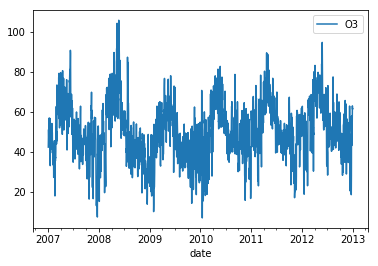

In [57]:
visual.plot(x='date', y = 'O3')

In [58]:
visualn = visual[['date','O3']].copy()
visualn.set_index('date',inplace=True)
visualn.head()


,O3
date,
2007-01-02,42.358
2007-01-03,49.506
2007-01-04,51.101
2007-01-05,47.478
2007-01-06,45.226


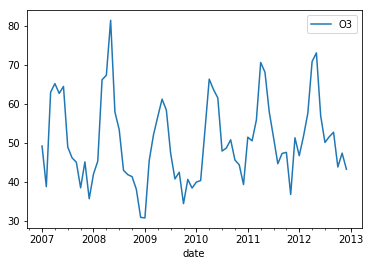

In [59]:
monthly = pd.DataFrame() 
monthly['O3'] = visualn.O3.resample('M').mean()
monthly.plot()

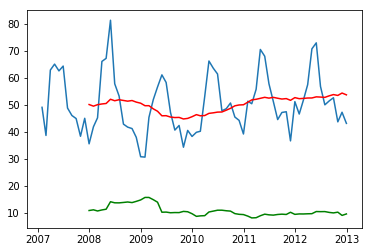

In [60]:
rolmean = monthly.rolling(window=12).mean()
rolstd = monthly.rolling(window=12).std()
orig = mplot.plot(monthly)
mean= mplot.plot(rolmean,color ='red', label = 'Rolling Mean')
std = mplot.plot(rolstd, color='green',label = 'Rolling STd')

In [61]:
# ADFuller test

def Fullertest(monthly):
    dftest = adfuller(monthly['O3'])
    print('ADF Stat: ', dftest[0])
    print('P-values: ', dftest[1])
    print('lages used: ', dftest[2])
    print('No. of observations: ', dftest[3])
    for key,value in dftest[4].items():
        print(key,value)
            

In [62]:
Fullertest(monthly)

ADF Stat:  -0.5737980178043673
P-values:  0.8767933714880736
lages used:  11
No. of observations:  60
1% -3.5443688564814813
5% -2.9110731481481484
10% -2.5931902777777776


,O3
date,
2007-01-31,3.894931
2007-02-28,3.656358
2007-03-31,4.142734
2007-04-30,4.177048
2007-05-31,4.137800


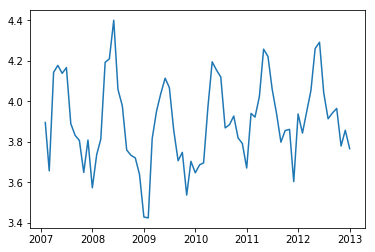

In [89]:
log_series= np.log(monthly)
mplot.plot(log_series)
log_series.head()

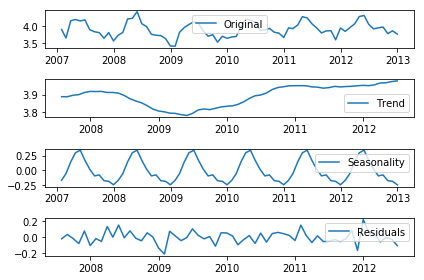

In [115]:
decomposition = seasonal_decompose(log_series)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
mplot.subplot(411)
mplot.plot(log_series, label='Original')
mplot.legend(loc='best')
mplot.subplot(412)
mplot.plot(trend, label='Trend')
mplot.legend(loc='best')
mplot.subplot(413)
mplot.plot(seasonal,label='Seasonality')
mplot.legend(loc='best')
mplot.subplot(414)
mplot.plot(residual, label='Residuals')
mplot.legend(loc='best')
mplot.tight_layout()

In [83]:
log_series_decompose= residual
log_series_decompose.dropna(inplace=True)
Fullertest(log_series_decompose)

ADF Stat:  -8.684686447201859
P-values:  4.194260325397687e-14
lages used:  0
No. of observations:  59
1% -3.5463945337644063
5% -2.911939409384601
10% -2.5936515282964665


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


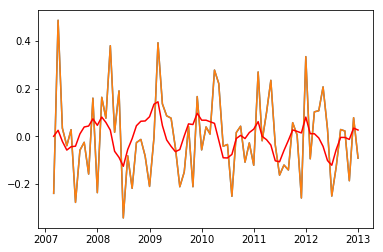

In [102]:
log_diff = log_series-log_series.shift()
mplot.plot(log_diff)
model = ARIMA(log_series, order=(1, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
mplot.plot(log_diff)
mplot.plot(results_ARIMA.fittedvalues, color='red')


In [111]:
#Take the predicted values and find cumsum
predicted_values=pd.Series(results_ARIMA.fittedvalues, copy=True)
predicted_values_cumsum = predicted_values.cumsum()

In [112]:
predictions_values_log=pd.Series(3.894931, index=log_series.index)
predictions_values_log = predictions_values_log.add(predicted_values_cumsum,fill_value=0)

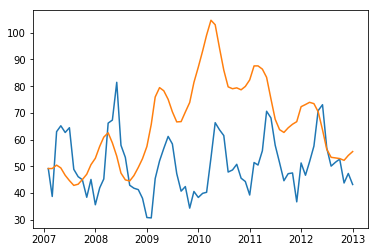

In [113]:
prediction = np.exp(predictions_values_log)
mplot.plot(monthly)
mplot.plot(prediction)